#### 데이터셋 불러오기

sklearn 패키지에서 제공하는 wine 분류 데이터셋을 사용했다. 또한, 총 13개 변수 중 Alcohol, Malic Acid 2개 변수만 사용했고 총 3개의 class중에서 class1과 class2만 사용했다.

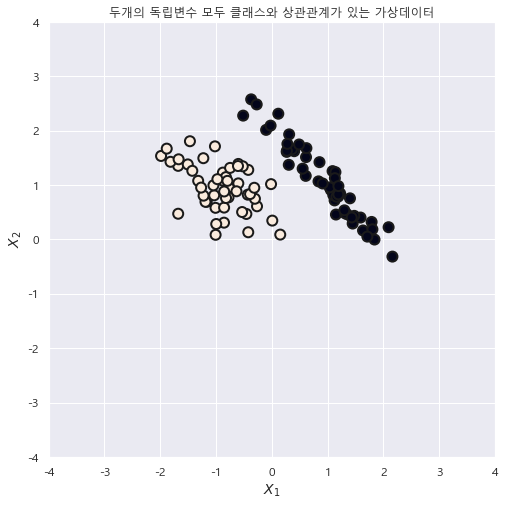

In [2]:
import os
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.svm import SVC
from sklearn import datasets
from sklearn.datasets import make_classification
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(8, 8))
plt.title("두개의 독립변수 모두 클래스와 상관관계가 있는 가상데이터")
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, random_state=11111)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=100, edgecolor="k", linewidth=2)

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

In [52]:
# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

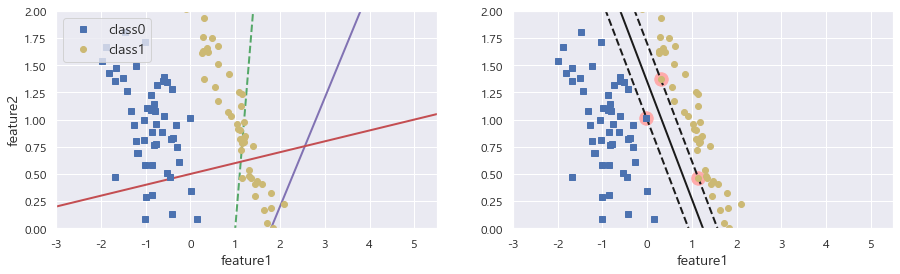

In [3]:
# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

x0 = np.linspace(-5, 5.5, 200)
pred_1 = 5*x0 - 5
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_  # support vectors
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="class0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="class1")
plt.xlabel("feature1", fontsize=14)
plt.ylabel("feature2", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 5.5, 0, 2])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf, -5, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("feature1", fontsize=14)
plt.axis([-3, 5.5, 0, 2])

plt.show()

#### Soft Margin Classification

상단의 SVM 방식은 Hard Margin SVM이라고 한다. 이 방식은 두 개의 클래스를 분리함에 있어서 모든 데이터 포인트가 분리 초평면을 기준으로 정확히 나누어져야 한다.
하지만 노이즈 또는 이상치, 두 클래스 사이의 overlap 등이 존재한다면 두 클래스를 엄격하게 분리하기는 힘들 것이다.
아래의 이상치가 존재하는 예시를 통해서 알아볼 것이다.

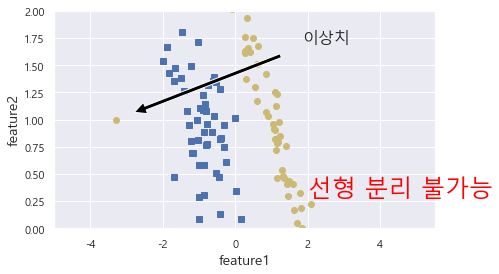

In [110]:
X_outliers = np.array([[-3.3, 1], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(2, 0.3, "선형 분리 불가능", fontsize=24, color="red")
plt.xlabel("feature1", fontsize=14)
plt.ylabel("feature2", fontsize=14)
plt.annotate("이상치",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([-5, 5.5, 0, 2])



plt.show()

위처럼 Hard Margin SVM이 적용되기 힘든 문제점들을 해결하기 위해서 Soft Margin SVM이 개발 되었다. Soft Margin SVM은 Hard Margin SVM의 support vector가 위치한 경계선에서 slack variable을 두어 오류를 허용해주는 방법이다.

여기서 선형 분리를 하기 힘든 예제를 다시 생성하였다.

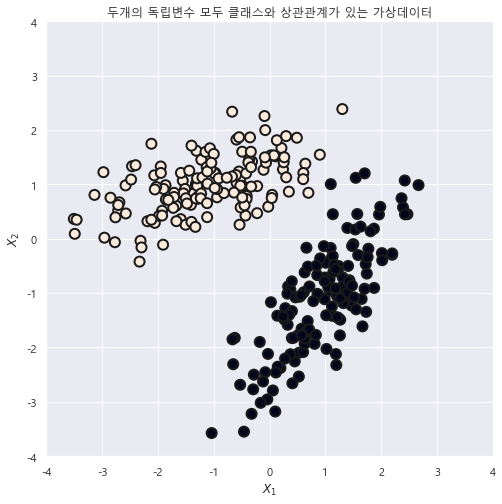

In [151]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

plt.figure(figsize=(8, 8))
plt.title("두개의 독립변수 모두 클래스와 상관관계가 있는 가상데이터")
X, y = make_classification(n_samples=290, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, random_state=220)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=100, edgecolor="k", linewidth=2)

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()


In [153]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [154]:

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)


b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]


plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="class0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="class1")
plot_svc_decision_boundary(svm_clf1, -10, 10)
plt.xlabel("feature1", fontsize=14)
plt.ylabel("feature2", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([-5, 5, -5, 5])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, -10, 10)
plt.xlabel("feature1", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([-5, 5, -5, 5]);

In [155]:
len(svm_clf1.support_vectors_)

9

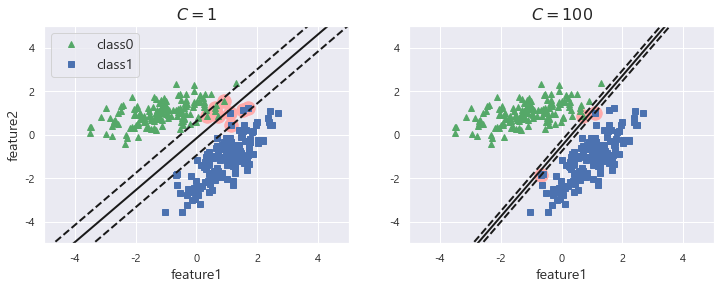

In [171]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="class0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="class1")
plot_svc_decision_boundary(svm_clf1, -10, 10)
plt.xlabel("feature1", fontsize=14)
plt.ylabel("feature2", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([-5, 5, -5, 5])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, -10, 10)
plt.xlabel("feature1", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([-5, 5, -5, 5]);

## NonLinear SVM classification
현실에는 선형적으로 분류할 수 없는 비선형성을 가진 데이터셋이 많다. 따라서 Hard Margin SVM과 Soft Margin SVM으로는 한계가 있을 것이다.
이러한 한계점을 개선하기 위해 kernel 함수를 이용하여 비선형을 고차원으로 만들어서 선형 분리가 가능하게끔 만들어주는 방법들이 있다.

아래는 sklearn에서 제공하는 make moons로 선형분류가 힘든 데이터셋을 임의로 만들었다. 만들어진 데이터셋에 Polynomial Kernel과 RBF Kernel을 적용할 것이다.

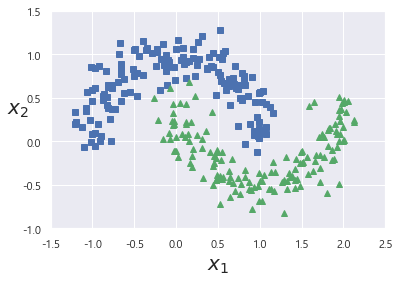

In [173]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.15, random_state=2022)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

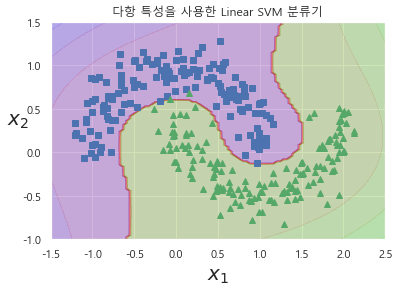

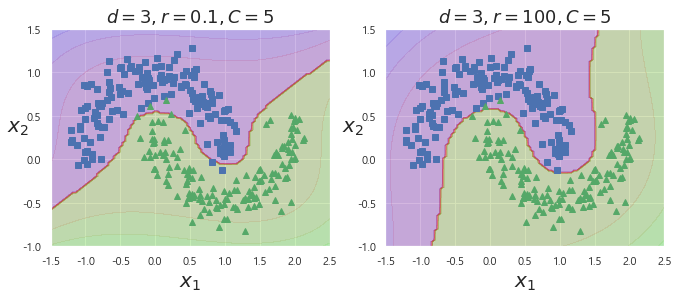

In [175]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))
])

polynomial_svm_clf.fit(X, y)
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title('다항 특성을 사용한 Linear SVM 분류기')
plt.show()

from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=0.1, C=5))
])

poly_kernel_svm_clf.fit(X, y)


poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=100, C=5))
    ])

poly100_kernel_svm_clf.fit(X, y)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=0.1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=100, C=5$", fontsize=18)

plt.show()

In [176]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])

rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

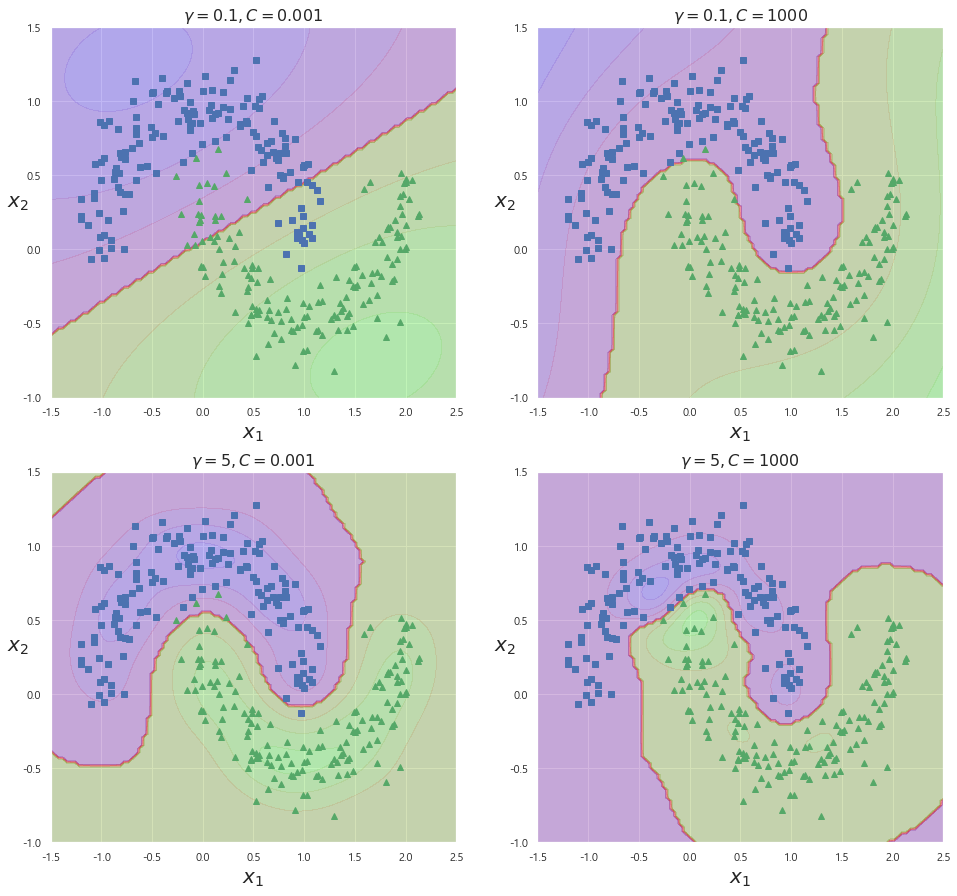

In [183]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(16, 15))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

plt.show()